# <font  color = "#0093AF"> Correlation-time dependence of a pulse-sequence: RECRR

In [1]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=16000,pwdavg=sl.PowderAvg()[5],n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,15*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=200e-6)

In [3]:
Ux=L.Sequence().add_channel('15N',v1=25000).U()
Umx=L.Sequence().add_channel('15N',v1=25000,phase=np.pi).U()
Upiy=L.Udelta('15N',phase=np.pi/2)
Upimy=L.Udelta('15N',phase=3*np.pi/2)

rho=sl.Rho('15Nx','15Nx')

rho,Ux,Umx,Upiy,Upimy=rho.ReducedSetup(Ux,Umx,Upiy,Upimy)

State-space reduction: 32->16


/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:648: UserWarning: Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho')


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

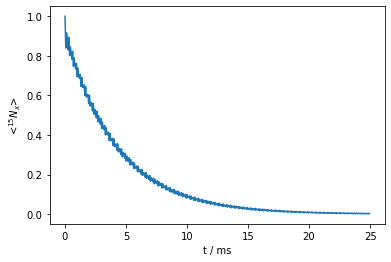

In [4]:
rho.clear()
rho.DetProp(Ux,n=400)
rho.plot()

/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:648: UserWarning: Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho')


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

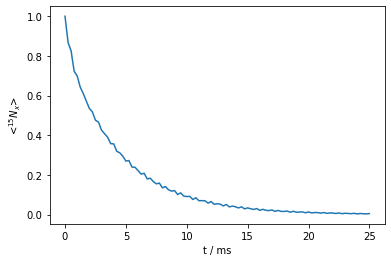

In [5]:
rho.clear()
Umx0=Umx
Ux0=Ux
rho()
for k in range(100):
    rho.reset()
    (Umx0*Upimy*Umx0*Ux0*Upiy*Ux0*rho)()
    Umx0=Umx*Umx0
    Ux0=Ux*Ux0
rho.plot()

In [6]:
tc0=np.logspace(-6,-3,25)
R1p_cw=[]
R1p_RECRR=[]
for tc in tc0:
    rho.reset()
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    
    Ux=L.Sequence().add_channel('15N',v1=25000).U()
    Umx=L.Sequence().add_channel('15N',v1=25000,phase=np.pi).U()
    Upiy=L.Udelta('15N',phase=np.pi/2)
    Upimy=L.Udelta('15N',phase=3*np.pi/2)

    rho=sl.Rho('15Nx','15Nx')

    rho,Ux,Umx,Upiy,Upimy=rho.ReducedSetup(Ux,Umx,Upiy,Upimy)
    
    R1p_cw.append(rho.extract_decay_rates(Ux,pwdavg=True))
    rho.reset()
    (Umx*Upimy*Umx*Ux*Upiy*Ux*rho)()
    R1p_RECRR.append((1-rho.I[0][-1])/rho.t)

State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


State-space reduction: 32->16
State-space reduction: 32->16


/Users/albertsmith/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


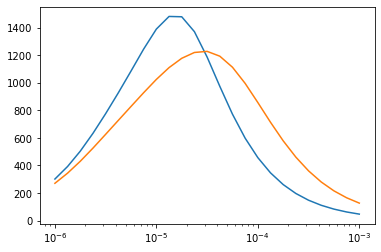

In [7]:
ax=plt.subplots()[1]
ax.semilogx(tc0,R1p_cw)
ax.semilogx(tc0,R1p_RECRR)

State-space reduction: 32->16


/Users/albertsmith/Documents/GitHub/SLEEPY/Rho.py:648: UserWarning: Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized propagator. Make sure reduction was perfomed with same Rho')


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

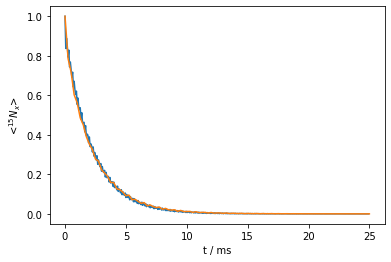

In [8]:
L.kex=sl.Tools.twoSite_kex(tc=10**-4)
    
Ux=L.Sequence().add_channel('15N',v1=25000).U()
Umx=L.Sequence().add_channel('15N',v1=25000,phase=np.pi).U()
Upiy=L.Udelta('15N',phase=np.pi/2)
Upimy=L.Udelta('15N',phase=3*np.pi/2)

rho=sl.Rho('15Nx','15Nx')

rho,Ux,Umx,Upiy,Upimy=rho.ReducedSetup(Ux,Umx,Upiy,Upimy)

ax=rho.DetProp(Ux,n=400).plot()

rho.clear()
Umx0=Umx
Ux0=Ux
rho()
for k in range(100):
    rho.reset()
    (Umx0*Upimy*Umx0*Ux0*Upiy*Ux0*rho)()
    Umx0=Umx*Umx0
    Ux0=Ux*Ux0
rho.plot(ax=ax)